# CNN在计算机视觉中的应用

## 图像增广
大规模数据集是成功应用深度神经网络的前提。图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，**随机改变训练样本可以降低模型对某些属性的依赖**，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。可以说，在当年AlexNet的成功中，图像增广技术功不可没。本节我们将讨论这个在计算机视觉里被广泛使用的技术。


In [2]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append("..") 
import dl_utils as dl
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

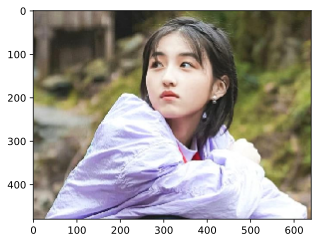

In [6]:
dl.set_figsize((5,10))
img = Image.open('imgs/zzf.jpg')
dl.plt.imshow(img)

部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个辅助函数apply。这个函数对输入图像img多次运行图像增广方法aug并展示所有的结果。


In [14]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = dl.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

## 随机翻转
左右翻转，是最早也是比较广泛的图像增广方式。


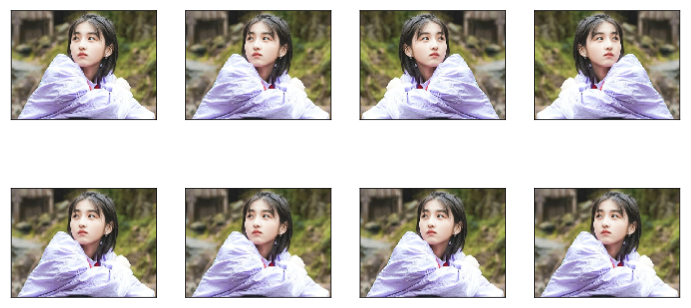

In [15]:
apply(img, torchvision.transforms.RandomHorizontalFlip(),scale = 3)

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们创建RandomVerticalFlip实例来实现一半概率的图像垂直（上下）翻转。

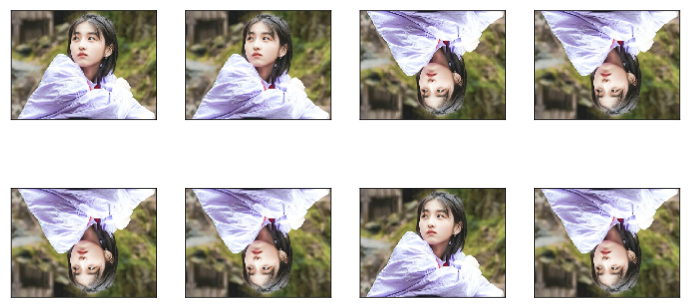

In [16]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的样例图像里，猫在图像正中间，但一般情况下可能不是这样。在5.4节（池化层）里我们解释了池化层能降低卷积层对目标位置的敏感度。除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。

在下面的代码里，我们每次随机裁剪出一块面积为原面积 
$10\% \sim 100\%$ 的区域，且该区域的宽和高之比随机取自$0.5 \sim 2$，然后再将该区域的宽和高分别缩放到200像素。若无特殊说明，本节中$a$和$b$之间的随机数指的是从区间$[a,b]$中随机均匀采样所得到的连续值。

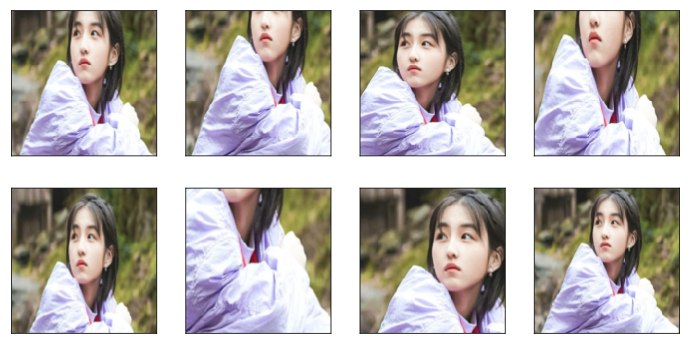

In [23]:
shape_aug = torchvision.transforms.RandomResizedCrop(150, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

## 变化颜色
另一类增广方法是变化颜色。我们可以从4个方面改变图像的颜色：亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。在下面的例子里，我们将图像的亮度随机变化为原图亮度的$50%$（$1-0.5$）$\sim 150%$（$1+0.5$）。

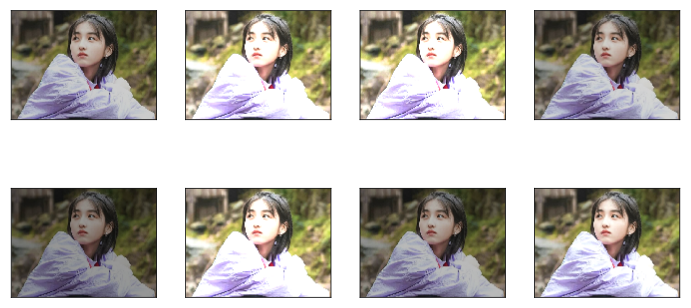

In [18]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

### 变化色调

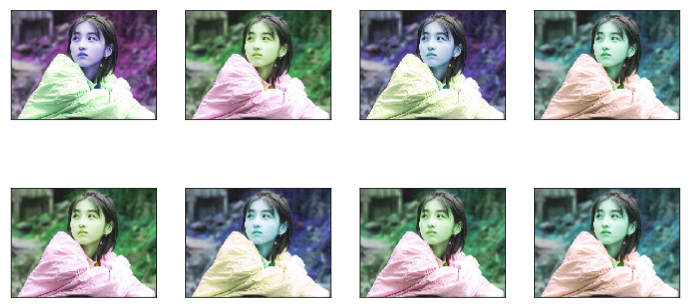

In [19]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

### 变换对比度

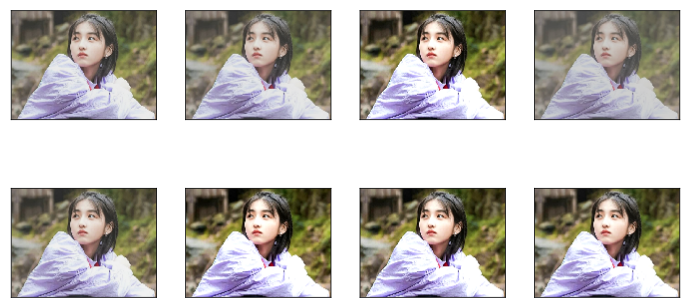

In [20]:
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

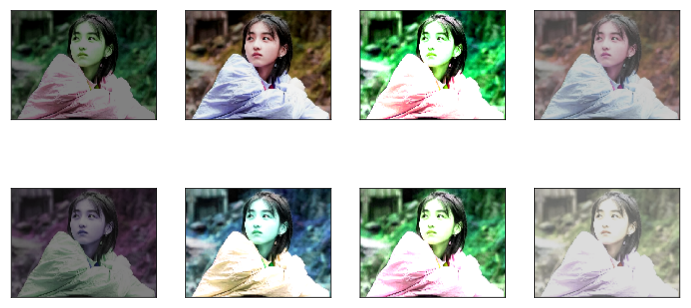

In [24]:
# 我们也可以同时设置如何随机变化图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。

color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

 ### 叠加多个图像增广方法
实际应用中我们会将多个图像增广方法叠加使用。我们可以通过Compose实例将上面定义的多个图像增广方法叠加起来，再应用到每张图像之上。

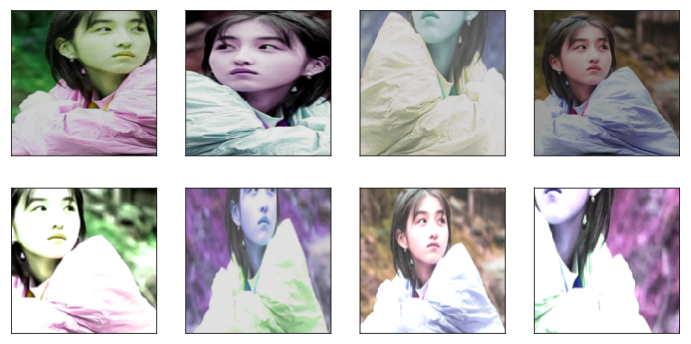

In [25]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)